# Deep Autoencoder
**Link**: https://colab.research.google.com/drive/1BNOZDm79nbegh9kzfpDgLL9f9U--bXjs?usp=sharing

We generate latent encodings for each cell based on gene expression vectors. Note this is a Colab notebook so we mount Google Drive to our notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!ls '/content/drive/My Drive/virtualitics_2021/data'

 barcodes.tsv	        drug_autoencoder      meta_celltypes.csv
'covid_data copy.csv'   fil_tags_binary.csv   meta.csv
 covid_four_drugs.csv   gene_autoencoder      normalized_data.mtx
 df_sampled.csv         info.txt	      tags.csv
 df_sampled_max.csv     matrix.mtx	      tags_distributions.png


In [4]:
data_path = '/content/drive/My Drive/virtualitics_2021/data'

## Preprocess Data

In [5]:
df_drugs = pd.read_csv(os.path.join(data_path, 'covid_four_drugs.csv'))
df_drugs

,cells,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,24520,24521,24522,24523,24524,24525,24526,24527,24528,24529,24530,24531,24532,24533,24534,24535,24536,24537,24538,24539,24540,24541,24542,24543,24544,24545,24546,24547,24548,24549,24550,24551,24552,24553,24554,24555,24556,cell_type,treatment,cell_barcode
0,11,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.386372,0.386372,0.0,0.0,0.0,0.0,0.0,0.000000,0.386372,0.0,0.0,0.0,0.0,0.0,0.386372,0.0,0.0,0.0,...,0.664368,0.0,0.0,0.0,0.000000,0.0,0.000000,0.386372,0.0,0.000000,0.0,0.0,0.664368,4.198055,3.631972,4.824847,5.098114,0.664368,5.032638,5.050924,4.669510,2.028522,4.729582,3.101146,1.060054,3.976894,0.0,0.0,0.0,0.0,0.386372,0.0,0.0,0.0,0.0,0.0,0.0,Myeloid,ALL CYTO,AAACCCACAGCTCTGG1
1,30,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,3.799901,3.303880,3.893175,4.741548,1.158401,4.962945,4.741548,4.576080,0.000000,4.620084,3.799901,0.000000,4.832590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,T cells,DASATINIB_ALL CYTO,AAACGAAAGAGCCCAA1
2,40,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.473236,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.793156,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,4.204165,4.047982,4.347082,4.784281,0.000000,5.166453,4.758659,4.683213,0.793156,4.595516,3.382472,0.793156,4.248360,0.0,0.0,0.0,0.0,0.473236,0.0,0.0,0.0,0.0,0.0,0.0,Myeloid,DASATINIB_ALL CYTO,AAACGAAGTCTCGCGA1
3,45,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.641892,4.082762,3.406335,5.170070,4.868402,0.000000,4.802241,4.693989,4.383696,1.641892,3.535712,3.083040,0.000000,4.214183,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,T cells,ALPROSTADIL_ALL CYTO,AAACGAATCGCCAATA1
4,49,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468829,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.383944,3.825575,3.838533,5.010184,4.981862,0.000000,4.918328,4.677172,4.782715,1.943224,4.787711,3.430953,0.786749,4.270793,0.0,0.0,0.0,0.0,0.468829,0.0,0.0,0.0,0.0,0.0,0.0,Myeloid,CYCLOSPORINE_ALL CYTO,AAACGCTCACAAGCAG1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978,47137,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.430001,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.960031,0.0,0.430001,0.000000,0.0,0.430001,0.0,0.0,0.729729,4.012106,3.941627,4.767163,5.034232,0.430001,5.239116,4.757983,4.841969,1.852006,4.871215,3.204346,1.147096,4.165060,0.0,0.0,0.0,0.0,0.430001,0.0,0.0,0.0,0.0,0.0,0.0,Myeloid,ALL CYTO,TTTGGTTGTGGATGAC2
4979,47141,0.0,0.0,0.0,0.0,1.153033,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2.015351,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.153033,0.0,0.000000,0.0,0.0,1.153033,4.313544,3.929059,3.296335,4.970327,0.000000,5.110491,4.049390

In [6]:
# Get to generate cell type/drug combinations
cell_types = df_drugs['cell_type'].unique()
drugs = df_drugs['treatment'].unique()

In [7]:
cell_types, drugs

(array(['Myeloid', 'T cells', 'B-cells'], dtype=object),
 array(['ALL CYTO', 'DASATINIB_ALL CYTO', 'ALPROSTADIL_ALL CYTO',
        'CYCLOSPORINE_ALL CYTO'], dtype=object))

In [8]:
# Create data set
X1 = []
X2 = []
i = 0
for cell_type in cell_types:
  for drug in drugs:
    # Get pertinent data
    data = df_drugs[(df_drugs['cell_type'] == cell_type) & (df_drugs['treatment'] == drug)]
    # One-hot encode cluster and repeat for all cells
    cluster_idx = tf.repeat(tf.reshape(tf.one_hot(i, len(cell_types) * len(drugs), \
                                                  dtype=tf.float64), (1, -1)), data.shape[0], axis=0).numpy()
    # Get gene expression vectors                 
    gene_exp = np.asarray(data.iloc[:, 1:-3])
    X1.append(cluster_idx)
    X2.append(gene_exp)
    i += 1
X1 = np.vstack(X1)
X2 = np.vstack(X2)
print(X1.shape, X2.shape)

(4983, 12) (4983, 24557)


In [10]:
# Hyperparameters
n_inputs_1 = len(cell_types) * len(drugs)
n_inputs_2 = df_drugs.shape[1] - 4
print(n_inputs_1, n_inputs_2)
batch_size = 16

12 24557


In [11]:
# Create `tf.data.Dataset` to train on
X1_data = tf.data.Dataset.from_tensor_slices(X1)
X2_data = tf.data.Dataset.from_tensor_slices(X2)
X_data = tf.data.Dataset.zip((X1_data, X2_data)).map(lambda x1, x2: {'x1': x1, 'x2': x2})
dataset = tf.data.Dataset.zip((X_data, X2_data)).shuffle(1000).batch(batch_size).cache()

In [11]:
dataset

<CacheDataset shapes: ({x1: (None, 12), x2: (None, 24557)}, (None, 24557)), types: ({x1: tf.float64, x2: tf.float64}, tf.float64)>

## Model

In [37]:
# This layer is for our drug/cell cluster
input_cluster = keras.Input(shape=(n_inputs_1,), name='x1')
# This layer is for our input vector
input_vector = keras.Input(shape=(n_inputs_2,), name='x2')

combined = keras.layers.Concatenate()([input_cluster, input_vector])

# These layers are for our encoder
encoder = keras.layers.Dense(2000, activation='relu')(combined)
encoder = keras.layers.Dense(1000, activation='relu')(encoder)
encoder = keras.layers.Dense(500, activation='relu')(encoder)
encoder = keras.layers.Dense(500, activation='relu')(encoder)

# Sigmoid is used here to output normalized values for latent encoding
latent_rep = keras.layers.Dense(128, activation='sigmoid')(encoder)

# These layers are for our decoder
decoder = keras.layers.Dense(500, activation='relu')(latent_rep)
decoder = keras.layers.Dense(500, activation='relu')(decoder)
decoder = keras.layers.Dense(1000, activation='relu')(decoder)
decoder = keras.layers.Dense(2000, activation='sigmoid')(decoder)

# Final reconstructed vector
reconstruction = keras.layers.Dense(n_inputs_2)(decoder)

In [38]:
model = keras.Model([input_cluster, input_vector], reconstruction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1 (InputLayer)                 [(None, 12)]         0                                            
__________________________________________________________________________________________________
x2 (InputLayer)                 [(None, 24557)]      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24569)        0           x1[0][0]                         
                                                                 x2[0][0]                         
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2000)         49140000    concatenate_1[0][0]        

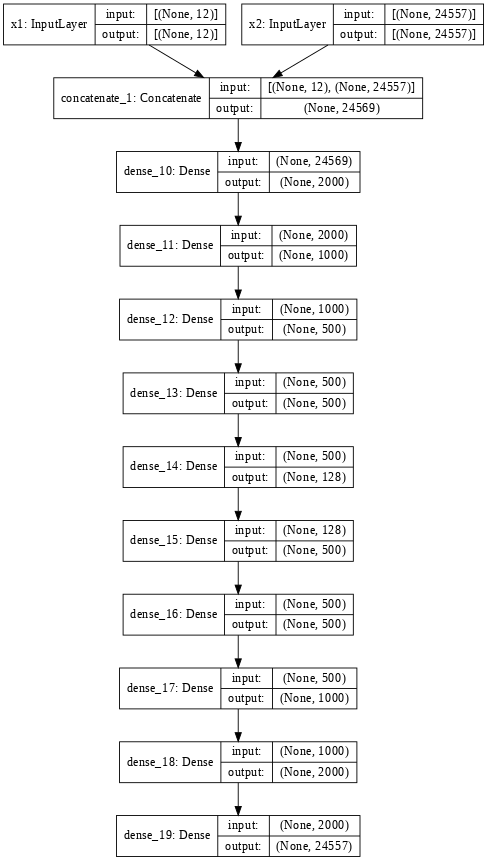

In [39]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [40]:
optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

In [41]:
model.compile(optimizer=optimizer, loss='mse', metrics=['acc'])

## Training

In [42]:
model.fit(dataset, epochs=100)

Epoch 1/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0610 - acc: 0.8079
Epoch 2/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0565 - acc: 0.8479
Epoch 3/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0558 - acc: 0.8465
Epoch 4/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0551 - acc: 0.8475
Epoch 5/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0545 - acc: 0.8463
Epoch 6/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0542 - acc: 0.8479
Epoch 7/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0539 - acc: 0.8523
Epoch 8/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0537 - acc: 0.8509
Epoch 9/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0535 - acc: 0.8537
Epoch 10/100
312/312 [==============================] - 6s 18ms/step - loss: 0.0534 - acc: 0.8565
Epoch 11/100
312/312 [=======

In [43]:
model.save(os.path.join(data_path, 'drug_autoencoder'))

INFO:tensorflow:Assets written to: /content/drive/My Drive/virtualitics_2021/data/drug_autoencoder/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/virtualitics_2021/data/drug_autoencoder/assets


In [44]:
model.evaluate(dataset)

312/312 [==============================] - 4s 10ms/step - loss: 0.0538 - acc: 0.8912


[0.05380792170763016, 0.8912301659584045]

## Generate Latent Encodings

In [9]:
new_model = keras.models.load_model(os.path.join(data_path, 'drug_autoencoder'))

In [12]:
new_model.evaluate(dataset)

312/312 [==============================] - 7s 12ms/step - loss: 0.0538 - acc: 0.8912


[0.053807903081178665, 0.8912301659584045]

In [23]:
# Extract encoder
encoder = keras.Model([new_model.layers[0].input, new_model.layers[1].input], new_model.layers[7].output)

In [24]:
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1 (InputLayer)                 [(None, 12)]         0                                            
__________________________________________________________________________________________________
x2 (InputLayer)                 [(None, 24557)]      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24569)        0           x1[0][0]                         
                                                                 x2[0][0]                         
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2000)         49140000    concatenate_1[0][0]        

In [26]:
# Get latent encodings for each cell
latent_encodings = encoder.predict([X1, X2])

In [27]:
latent_encodings.shape

(4983, 128)

In [28]:
# Save training data and latent encodings
with open(os.path.join(data_path, 'x1.npy'), 'wb') as f:
    np.save(f, X1)
with open(os.path.join(data_path, 'x2.npy'), 'wb') as f:
    np.save(f, X2)
with open(os.path.join(data_path, 'latent_encodings.npy'), 'wb') as f:
    np.save(f, latent_encodings)